<H3>Effects of market movements + liquidity add on LRNA price</H3>
In this notebook, we look at the effects on LRNA price when liquidity is added during a temporary price move. That is, we set the prices of the assets, then move the market up or down, then add a large amount of liquidity (currently at 10% of the entire Omnipool TVL) right at the peak of the price move. We then move the market back to where it began and observe the difference in LRNA price between the starting and ending conditions.

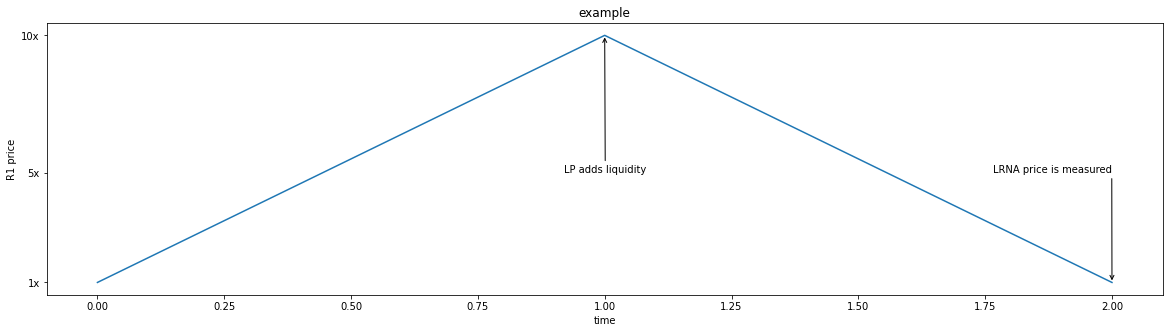

In [1]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 5))
plt.title('example')
plt.xlabel('time')
plt.ylabel('R1 price')
plt.yticks(
    [1, 5, 10],
    ['1x', '5x', '10x']
)
plt.annotate(
    text='LP adds liquidity',
    xy=(1, 10),
    xytext=(0.92, 5),
    arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
)
plt.annotate(
    text='LRNA price is measured',
    xy=(2, 1),
    xytext=(1.765, 5),
    arrowprops={'arrowstyle': '->', 'relpos': (1, 0.5)}
)
plt.plot([0, 1, 2], [1, 10, 1])

In [77]:
import random
import sys
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, lrna_price, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, withdraw_all
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from IPython.display import display, Markdown

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.05},
    'USD': {'usd price': 1, 'weight': 0.20},
    'R1': {'usd price': 1, 'weight': 0.05},
    'R2': {'usd price': 2/3, 'weight': 0.65},
}

lrna_price_usd = 1
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}
price_move_assets = ['R1']
time_steps = 110
plateau_length = 5

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            lrna_fee=0.0005,
            asset_fee=0.0025
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={tkn: 1000000000000 for tkn in list(assets.keys()) + ['LRNA']},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=2
            )
        ),
        'LP': Agent(
            holdings={'R1': liquidity['R1']},
            trade_strategy=invest_all(
                pool_id='omnipool',
                when=int(time_steps / 2)
            )
        )
    },
    evolve_function=historical_prices(price_list=[
        {
            tkn: assets[tkn]['usd price'] * (
                10 - (abs(i * 2 - (time_steps - plateau_length - 1)) / (time_steps - plateau_length - 1) * (10 - 1))
            )
            for tkn in price_move_assets
        } 
        for i in range(time_steps - plateau_length)
    ] + [{tkn: assets[tkn]['usd price'] for tkn in price_move_assets}] * (1 + plateau_length)),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)

<H3>Changing the degree of price move</H3>
In the first experiment, we set the initial weight of R1 at 5% of the pool, then have the LP add another 5%. We vary the peak price movement from -90% to 10x and then observe the final price of LRNA.

In [44]:
%matplotlib inline

price_min = 0.1
price_max = 10
steps = 100
price_list = [price_min * ((price_max / price_min) ** (1 / (steps - 1))) ** i for i in range(steps)]
price_moves = {  # {0.1: '-90%', 0.5: '-50%', 2: '2x', 10: '10x'}
    price:
    (
        f"-{round((1 - price) * 100)}%"
        if price < 1 else
        f"{round(price)}x"
    )
    for price in price_list
}

price_move_assets = ['R1']
price_events = []
time_steps = 110
experiment_1 = initial_state.copy()

for pump_factor in price_moves:
    for tkn, info in assets.items():
        liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
        lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

    experiment_1._evolve_function=historical_prices(price_list=[
        {
            tkn: assets[tkn]['usd price'] * (
                pump_factor - (abs(i * 2 - (time_steps - plateau_length - 1)) / (time_steps - plateau_length - 1) * (pump_factor - 1))
            )
            for tkn in price_move_assets
        } 
        for i in range(time_steps - plateau_length)
    ] + [{tkn: assets[tkn]['usd price'] for tkn in price_move_assets}] * (1 + plateau_length))
    
    price_events.append([initial_state.copy()] + run.run(experiment_1, time_steps=time_steps, silent=True))
    

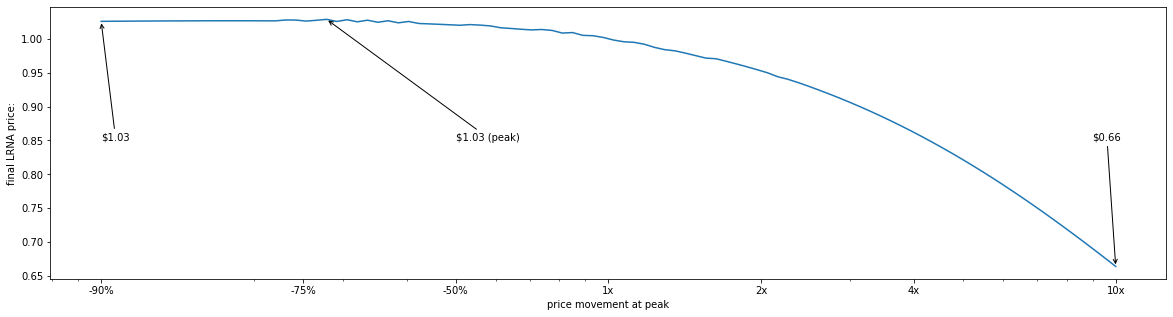

In [45]:
plt.figure(figsize=(20, 5))
plt.xscale('log')
# plt.yscale('log')
plt.xticks(
    [0.1, 0.25, 0.5, 1, 2, 4, 10],
    ['-90%', '-75%', '-50%', '1x', '2x', '4x', '10x']
)
plt.xlabel('price movement at peak')
plt.ylabel('final LRNA price:')

lrna_prices = [1 / lrna_price(events[-1].pools['omnipool'], 'USD') for events in price_events]
plt.annotate(
    xy=(list(price_moves.keys())[lrna_prices.index(max(lrna_prices))], max(lrna_prices)),
    xytext=(0.5, 0.85),
    text=f"${round(max(lrna_prices), 2)} (peak)",
    arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
)
plt.annotate(
    xy=(0.1, lrna_prices[0]),
    xytext=(0.1, 0.85),
    text=f"${round(lrna_prices[0], 2)}",
    arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
)
plt.annotate(
    xy=(10, lrna_prices[-1]),
    xytext=(9, 0.85),
    text=f"${round(lrna_prices[-1], 2)}",
    arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
)
plt.plot(price_moves.keys(), lrna_prices)

<H4>Varying the weight of R1</H4>
In the next experiment, we vary the initial weight of R1 from 0.1% to 10% of the pool, half of which is contributed by a single LP who withdraws at the peak of the price movement. We measure the final price of LRNA as a function of the initial weight of R1 for two cases: a 50% temporary price drop and a 10x price spike.

There is a sweet spot here, because although a higher weight initially increases the effect of the price move, it also means that LRNA price stays more closely tied to TKN price, and this effect eventually dominates, causing LRNA price . For that reason, the peak is found somewhere between the two extremes.

In [107]:
price_moves = {0.5: '-50%', 10: '10x'}
tkn_weight_min = 0.01
tkn_weight_max =0.80
tkn_weight_steps = 101
tkn_weights = [tkn_weight_min + (tkn_weight_max - tkn_weight_min) / (tkn_weight_steps - 1) * i for i in range(tkn_weight_steps)]
experiment_2 = initial_state.copy()
weight_events = {}

for pump_factor in price_moves:
    weight_events[pump_factor] = []
    experiment_2._evolve_function = historical_prices(price_list=[
        {
            tkn: assets[tkn]['usd price'] * (
                pump_factor - (abs(i * 2 - (time_steps - plateau_length - 1)) / (time_steps - plateau_length - 1) * (pump_factor - 1))
            )
            for tkn in price_move_assets
        } 
        for i in range(time_steps - plateau_length)
    ] + [{tkn: assets[tkn]['usd price'] for tkn in price_move_assets}] * (1 + plateau_length))
    
    for weight in tkn_weights:
        assets['R1']['weight'] = weight
        assets['R2']['weight'] = 0.75 - (weight * 2)
        experiment_2.pools['omnipool'].liquidity['USD'] = initial_omnipool_tvl * 0.14
        experiment_2.pools['omnipool'].lrna['USD'] = initial_omnipool_tvl * 0.14 / lrna_price_usd
        experiment_2.pools['omnipool'].liquidity['R1'] = initial_omnipool_tvl * weight / 2 / assets['R1']['usd price']
        experiment_2.pools['omnipool'].lrna['R1'] = initial_omnipool_tvl * weight / 2 / lrna_price_usd
        experiment_2.pools['omnipool'].liquidity['R2'] = initial_omnipool_tvl * (0.81 - weight) / assets['R2']['usd price']
        experiment_2.pools['omnipool'].lrna['R2'] = initial_omnipool_tvl * (0.81 - weight) / lrna_price_usd
        experiment_2.agents['LP'].holdings['R1'] = initial_omnipool_tvl * weight / 2 / assets['R1']['usd price']
        # expermient_2 = run.run(experiment_2, time_steps)[-1]
        # print(experiment_2.pools['omnipool'])
 
        weight_events[pump_factor].append([experiment_2] + run.run(experiment_2, time_steps=time_steps, silent=True))

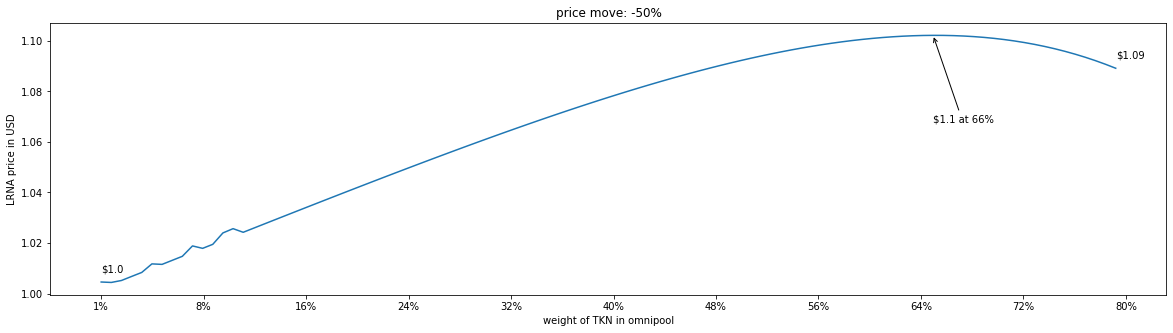

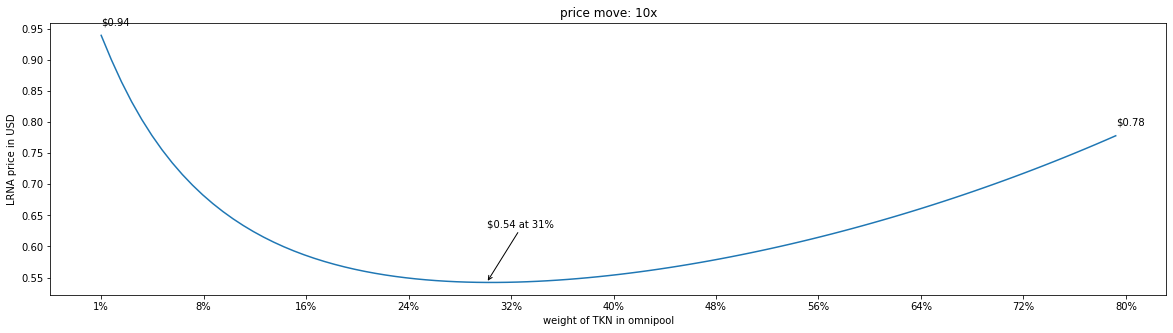

In [123]:
for pump_factor in weight_events:
    events = [weight_run[-1] for weight_run in weight_events[pump_factor]]
    plt.figure(figsize=(20, 5))
    plt.plot([1 / x for x in pu.get_datastream(events, pool='omnipool', prop='lrna_price', key='USD')])
    plt.xlabel('weight of TKN in omnipool')
    plt.ylabel('LRNA price in USD')
    ticks_number = len(tkn_weights[::10])
    plt.xticks(
        [1 / (ticks_number - 1) * i * len(events) for i in range(ticks_number)],
        [f'{int(i * 100)}%' for i in tkn_weights[::10]]
    )
    plt.title(f"price move: {price_moves[pump_factor]}")
    lrna_prices = [1 / lrna_price(event.pools['omnipool'], 'USD') for event in events]
    plt.annotate(
        str(f"${round(lrna_prices[0], 2)}"), 
        xy=(0, lrna_prices[0]), 
        xytext=(0,10), 
        textcoords='offset points'
    )
    plt.annotate(
        str(f"${round(lrna_prices[-1], 2)}"), 
        xy=(len(events), lrna_prices[-1]), 
        xytext=(-10,10), 
        textcoords='offset points'
    )
    peak = lrna_prices.index(max(lrna_prices))
    if peak == len(lrna_prices) - 1 or peak == 0:
        peak = lrna_prices.index(min(lrna_prices))
    plt.annotate(
        str(f"${round(lrna_prices[peak], 2)} at {round(tkn_weights[peak] * 100)}%"), 
        xy=(peak, lrna_prices[peak]), 
        xytext=(peak, sum(lrna_prices) / len(lrna_prices)), 
        # textcoords='offset points',
        arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0)}
    )
    plt.show()

<H4>Varying the percentage of liquidity contributed by LP</H4>
In this experiment, we set the total weight of R1 at 5%, 1-75% of which is contributed by a single LP who then withdraws it at the peak of the price move. We measure the final price of LRNA as a function of the contribution from the LP for the same two cases: -50% and 10x. 

In [21]:
price_moves = {0.5: '-50%', 10: '10x'}
weight = 0.05
lp_percent = [0.00742574257 * i for i in range(1, 102)]
lp_events = {}
experiment_3 = initial_state.copy()

for pump_factor in price_moves:
    lp_events[pump_factor] = []
    experiment_3._evolve_function=historical_prices(
        price_list=[
            {
                tkn: assets[tkn]['usd price'] * (
                    pump_factor - (abs(i * 2 - (time_steps - plateau_length - 1)) / (time_steps - plateau_length - 1) * (pump_factor - 1))
                )
                for tkn in price_move_assets
            } 
            for i in range(time_steps - plateau_length)
        ] + [{tkn: assets[tkn]['usd price'] for tkn in price_move_assets}] * (1 + plateau_length)
    )
    for percent in lp_percent:
        experiment_3.pools['omnipool'].liquidity['R1'] = initial_omnipool_tvl * weight * (1 - percent) / assets['R1']['usd price']
        experiment_3.pools['omnipool'].lrna['R1'] = initial_omnipool_tvl * weight * (1 - percent) / lrna_price_usd
        experiment_3.agents['LP'].holdings['R1'] = initial_omnipool_tvl * weight * percent / assets['R1']['usd price']
        lp_events[pump_factor].append(run.run(experiment_3, time_steps=time_steps, silent=True))

<Figure size 1440x360 with 0 Axes>

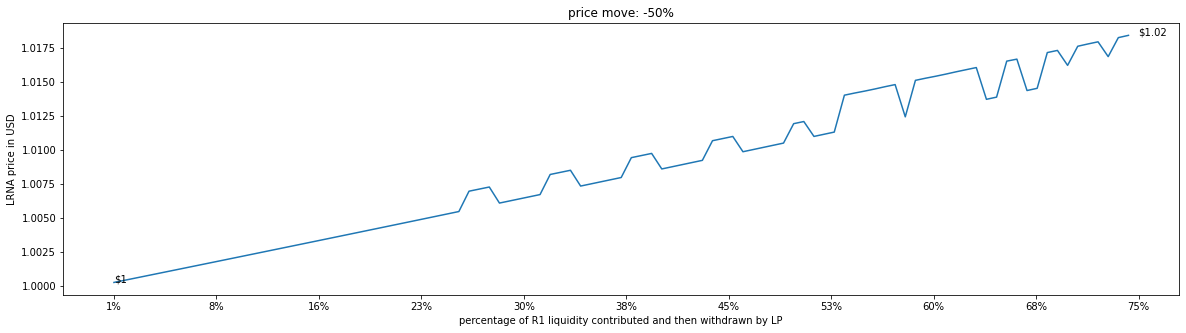

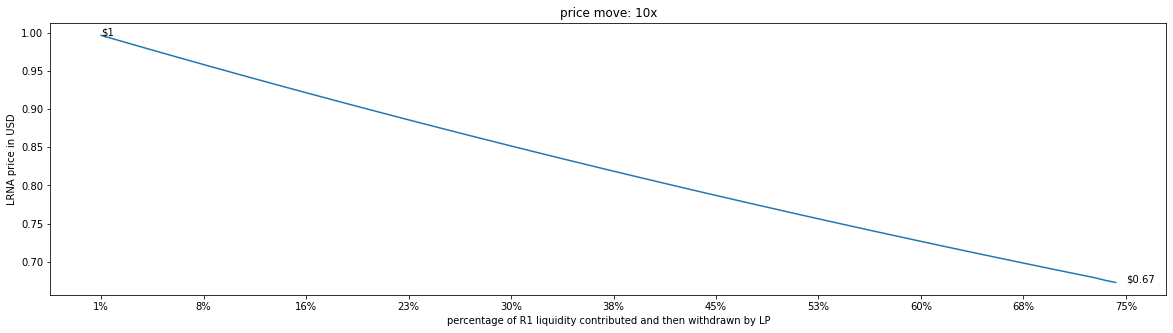

In [42]:
plt.figure(figsize=(20, 5))
    
for pump_factor in price_moves:
    price_run = lp_events[pump_factor]
    plt.figure(figsize=(20, 5))
    # plt.plot(range(len(price_run)), pu.get_datastream([events[-1] for events in price_run], pool='omnipool', prop='liquidity', key='R1'))  # [1 / x for x in pu.get_datastream([events[-1] for events in price_run], pool='omnipool', prop='lrna_price', key='USD')])
    lrna_prices = [1 / x for x in pu.get_datastream([events[-1] for events in price_run], pool='omnipool', prop='lrna_price', key='USD')]
    plt.plot(lrna_prices)
    plt.xlabel('percentage of R1 liquidity contributed and then withdrawn by LP')
    plt.ylabel('LRNA price in USD')
    ticks_number = len(lp_percent[::10])
    plt.xticks(
        [1 / (ticks_number - 1) * i * len(events) for i in range(ticks_number)],
        [f'{round(i * 100)}%' for i in lp_percent[::10]]
    )
    plt.title(f"price move: {price_moves[pump_factor]}")
    plt.annotate(
        str(f"${lrna_price_usd}"), 
        xy=(0, lrna_prices[0]), 
        # xytext=(lp_percent[0], len(price_run) - 1), 
    )
    plt.annotate(
        str(f"${round(lrna_prices[-1], 2)}"), 
        xy=(len(events), lrna_prices[-1]), 
        # xytext=(lp_percent[-10], len(price_run) - 1), 
        # textcoords='offset points'
    )
plt.show()